In [18]:
import typing
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg
import skimage


def expSampleInterval(k, n_to_show):
    max_exp = math.log(k, 2)
    d = max_exp / (n_to_show - 1)
    indexes = [int(2 ** (d * i)) - 1 for i in range(n_to_show)]
    return indexes

def

def visualizeDigitWithLabel(digit: np.ndarray, label: int):
    plt.imshow(digit.reshape(28,28), cmap="gray")
    plt.show()
    print("The label is: ", label)

In [2]:
full_dataset = pd.read_csv("./data.csv")

print("The head of the dataset is: ")
print(full_dataset.head(5), end="\n\n")

print("The dataset has shape: ")
print(full_dataset.shape)

The head of the dataset is: 
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0

In [25]:
X = full_dataset.values[:,1:]
y = full_dataset.values[:,0]

CHOSEN_LABELS = [1, 7, 9, 8, 0]
CHOSEN_INDEXES = np.where(np.isin(y, CHOSEN_LABELS))[0]
X = X[CHOSEN_INDEXES, :]
y = y[CHOSEN_INDEXES]

N_TRAIN = int(len(y) * 0.75)
shuffled_indexes = np.arange(len(y))
np.random.shuffle(shuffled_indexes)
X_train, y_train = X[shuffled_indexes[:N_TRAIN], :], y[shuffled_indexes[:N_TRAIN]]
X_test, y_test = X[shuffled_indexes[N_TRAIN:], :], y[shuffled_indexes[N_TRAIN:]]

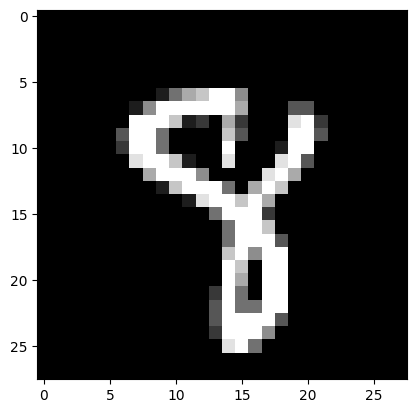

The label is:  8


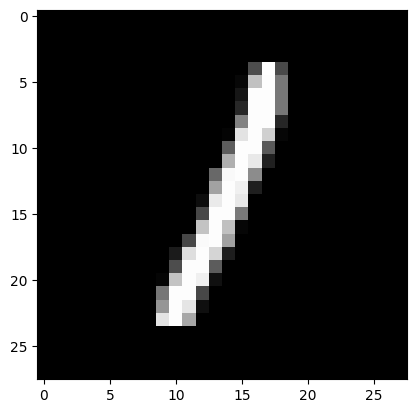

The label is:  1


In [26]:
visualizeDigitWithLabel(X_train[449,:], y_train[449])
visualizeDigitWithLabel(X_test[449,:], y_test[449])

In [27]:
def pca(X: np.ndarray, k: int = 2) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    standardized_X = X.copy()
    standardized_X = standardized_X - np.mean(X, axis=0)
    u, s, v_t = np.linalg.svd(standardized_X, full_matrices=False)
    explained_variance_ = (s**2) / (X.shape[0] - 1)
    transformed_X = u[:,:k] * s[:k]
    
    return v_t[:k,:], explained_variance_[:k], transformed_X

def computeCentroids(X: np.ndarray, y: np.ndarray) -> typing.Tuple[np.ndarray, typing.List[int]]:
    labels = np.sort(np.unique(y))
    centroids = np.zeros((labels.shape[0], X.shape[1]), dtype=np.float32)
    for i in range(labels.shape[0]):
        centroids[i] = np.mean(X[y == labels[i]], axis=0)
    
    return centroids, list(labels)

def lda(X: np.ndarray, y: np.ndarray, k: int):
    X_c = X.copy()[np.argsort(y), :].astype("float64")
    y = np.sort(y.copy())
    
    centroids, labels = computeCentroids(X_c, y)
    global_centroid = np.mean(X_c, axis=0)
    
    s_b = np.zeros(X_c.shape, dtype=np.float64)
    
    for idx, label in enumerate(labels):
        X_c[y == label] -= centroids[idx]
        s_b[y == label, :] = centroids[idx]
        
    s_w = X_c.T @ X_c
    
    s_b -= global_centroid
    s_b = s_b.T @ s_b
    
    try:
        L = np.linalg.cholesky(s_w)
    except:
        epsilon = 1e-6
        s_w = s_w + epsilon * np.eye(s_w.shape[0])
        L = np.linalg.cholesky(s_w)

    eigvals, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ s_b @ L, k=k)
    W = np.real(W)
    eigvals = np.real(eigvals)

    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X.T
    
    return eigvals, Z.T

def plotClusters(data: typing.Tuple[np.ndarray, np.ndarray], centroids: np.ndarray, labels: typing.List[int], title: str = ""):
    X, y = data
    n_labels = len(labels)
    colors  = plt.cm.rainbow(np.linspace(0, 1, n_labels))
    
    for i in range(n_labels):
        plt.scatter(X[y==labels[i]][:,0], X[y==labels[i]][:,1], color=colors[i], s=10, alpha=0.2, marker=".")
    
    for i in range(n_labels):
        plt.scatter(centroids[i][0], centroids[i][1], color=colors[i] / 2., label="Class {label}".format(label=labels[i]), s=80, alpha=1, marker="*")
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def avgDistancesFromCentroids(data: typing.Tuple[np.ndarray, np.ndarray], centroids: np.ndarray, labels: typing.List[int]):
    X, y = data
    n_labels = len(labels)
    
    distances = np.zeros((n_labels,), dtype=np.float32)
    for i in range(n_labels):
        distances[i] = np.mean(np.einsum("ij,ij->i", X[y==labels[i]] - centroids[i], X[y==labels[i]] - centroids[i]), axis=0)
        
    return distances

def clusteringClassifier(X: np.ndarray, centroids: np.ndarray, labels: typing.List[int]) -> np.ndarray:
    n_labels = len(labels)
    distances = np.zeros((X.shape[0], n_labels), dtype=np.float32)
    for i in range(n_labels):
        distances[:, i] = np.einsum("ij,ij->i", X - centroids[i], X - centroids[i])
    
    y_pred = np.array([labels[idx] for idx in np.argmin(distances, axis=1)])
    return y_pred

def clusteringClassifier(X: np.ndarray, centroids: np.ndarray, labels: typing.List[int]) -> np.ndarray:
    n_labels = len(labels)
    distances = np.zeros((X.shape[0], n_labels), dtype=np.float32)
    for i in range(n_labels):
        distances[:, i] = np.einsum("ij,ij->i", X - centroids[i], X - centroids[i])
    
    y_pred = np.array([labels[idx] for idx in np.argmin(distances, axis=1)])
    return y_pred

def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(y_true == y_pred)

In [28]:
pcs_train, explained_variance_train, pca_X_train = pca(X_train, k=2)
centroids, labels = computeCentroids(pca_X_train, y_train)

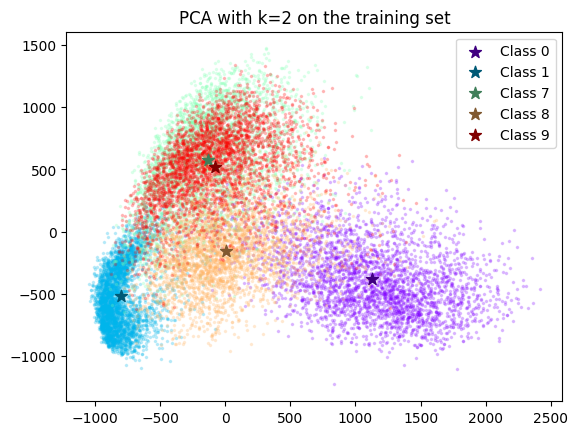

array([296534.12,  88888.48, 256250.31, 211294.27, 223332.36],
      dtype=float32)

In [29]:
plotClusters((pca_X_train, y_train), centroids=centroids, labels=labels, title="PCA with k=2 on the training set")
avgDistancesFromCentroids((pca_X_train, y_train), centroids=centroids, labels=labels)

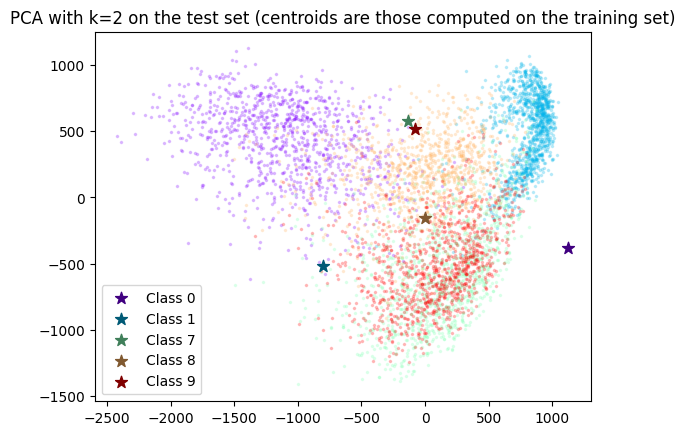

array([5833196.5 , 3734320.8 , 1651224.1 ,  331838.28, 1291653.8 ],
      dtype=float32)

In [30]:
pcs_test, explained_variance_test, pca_X_test = pca(X_test, k=2)
plotClusters((pca_X_test, y_test), centroids=centroids, labels=labels, 
             title="PCA with k=2 on the test set (centroids are those computed on the training set)")
avgDistancesFromCentroids((pca_X_test, y_test), centroids=centroids, labels=labels)

In [31]:
_, lda_X_train = lda(X_train, y_train, 2)

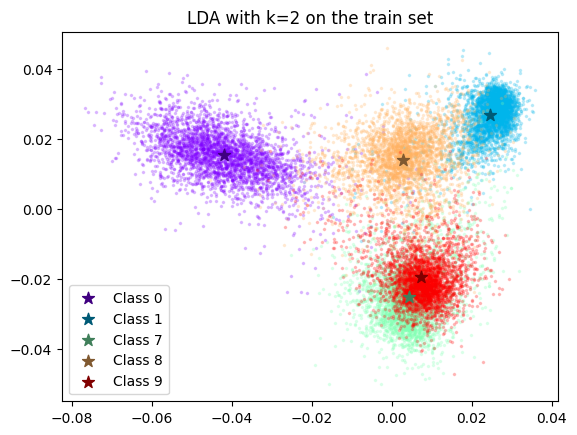

In [32]:
centroids, labels = computeCentroids(lda_X_train, y_train)
plotClusters((lda_X_train, y_train), centroids, labels, "LDA with k=2 on the train set")

In [21]:
pca_classification_accuracy = []
ks = [1, 2, 5, 10, 40, 80, 160, 320, 640]

In [24]:
ks

[0, 1, 3, 8, 18, 39, 84, 177, 372, 782]

## VISUALIZING DYADS

In [ ]:
import skimage
import math

In [ ]:
def kRankApproximation(u: np.ndarray, s: np.ndarray, v: np.ndarray, k: int):
    approximation = np.zeros((512, 512))
    approximation += s[i] * u[:,i].reshape(-1,1) * v[i].reshape(1,-1)
    return approximation

def plotFFT(image: np.ndarray):
    fft_img = np.fft.fftshift(np.fft.fft2(image))
    plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(np.log(abs(fft_img)), cmap='gray');
    plt.show()

def visualizeDyads(skimage_ref: typing.Callable):
    image_as_array: np.ndarray = skimage_ref()
    
    assert len(image_as_array.shape) == 2, "Only grayscale images are allowed"

    print("The original image is the following:")
    plt.imshow(image_as_array, cmap="gray")
    plt.show()
    
    m, n = image_as_array.shape
    k = min(m, n)
    
    u, s, v_t = np.linalg.svd(image_as_array)
    
    dyads = [s[i] * u[:,i].reshape(-1,1) * v_t[i].reshape(1,-1) for i in range(k)]
    k_rank_approximations = np.cumsum(dyads, axis=0)
    approximation_error = [np.linalg.norm(image_as_array - k_rank_approximations[i], ord=2) 
                           for i in range(k)]
    stds = [np.std(dyads[i]) for i in range(k)]
    
    selected_dyads = expSampleInterval(k, 5)
    for i in selected_dyads:
        dyad = dyads[i]
        print("dyad numer %d:" % (i + 1))
        plt.imshow(dyad, cmap="gray")
        plt.show()
        print("Fourier transform of the dyad: ")
        plotFFT(dyad)
        print("\n\n")
        
        
    plt.plot(np.arange(k), stds)
    plt.show()

    plt.plot(np.arange(k), s)
    plt.show()
    
    for i in selected_dyads:
        plt.imshow(k_rank_approximations[i, :], cmap="gray")
        plt.show()
    
    plt.plot(np.arange(k), approximation_error)
    plt.show()
    
    compression_factors = np.arange(k) / (image_as_array.shape[0] * image_as_array.shape[1])
    plt.plot(np.arange(k), compression_factors)
    plt.show()

In [ ]:
visualizeDyads(skimage.data.camera)